# Project Report: Predictive Modeling and Churn Analysis
This report outlines our approach to building a predictive churn model, detailing the process from defining churn to evaluating various machine learning models. The core objective was to develop a robust model that can accurately predict at-risk users, providing actionable insights for retention efforts.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV make a slide from this library . slide to show this library

In [ ]:
df = pd.read_excel("Cleaned & featured data.csv")
df.head()

,Learner SignUp DateTime,Opportunity Id,Opportunity Name,Opportunity Category,Opportunity End Date,First Name,Date of Birth,Gender,Country,Institution Name,...,Region_Opportunity,Engagement_Score,Engagement_Level,Apply_vs_Start_Gap,Applications_per_User,Unique_Categories_per_User,Region_AgeGroup,Applications_for_Opportunity,Region_Normalized_Applications,User_Success_Rate
0,2023-06-14 12:30:35,00000000-0GN2-A0AY-7XK8-C5FZPP,Career Essentials: Getting Started with Your P...,Course,2024-06-29 18:52:39,Faria,2001-12-01,Female,Pakistan,NWIHS,...,South_Asia_Course,1.0,High,-460,1,1,South_Asia_Young_Adult,1423,1.0,1.000000
1,2023-01-05 05:29:16,00000000-0GN2-A0AY-7XK8-C5FZPP,Career Essentials: Getting Started with Your P...,Course,2024-06-29 18:52:39,Poojitha,2000-08-16,Female,India,Saint Louis University,...,South_Asia_Course,1.0,High,-300,14,2,South_Asia_Young_Adult,1423,1.0,0.142857
2,2023-09-04 20:35:08,00000000-0GN2-A0AY-7XK8-C5FZPP,Career Essentials: Getting Started with Your P...,Course,2024-06-29 18:52:39,Emmanuel,2002-01-27,Male,United States,Illinois Institute of Technology,...,North_America_Course,0.6,High,-604,17,3,North_America_Young_Adult,1423,1.0,0.470588
3,2023-08-29 05:20:03,00000000-0GN2-A0AY-7XK8-C5FZPP,Career Essentials: Getting Started with Your P...,Course,2024-06-29 18:52:39,Amrutha Varshini,1999-01-11,Female,United States,Saint Louis University,...,North_America_Course,0.6,High,-549,13,3,North_America_Adult,1423,1.0,0.384615
4,2023-06-01 15:26:36,00000000-0GN2-A0AY-7XK8-C5FZPP,Career Essentials: Getting Started with Your P...,Course,2024-06-29 18:52:39,Vinay Varshith,2000-04-19,Male,United States,Saint Louis University,...,North_America_Course,1.0,High,-447,1,1,North_America_Young_Adult,1423,1.0,1.000000


# The Churn Definition Challenge

A key obstacle was the absence of an explicit “churned” label in the dataset. To overcome this, we adopted a data-driven, rule-based approach supported by clustering.

We applied K-Means clustering to determine natural thresholds for critical behavioral features:

Engagement_Score

Applications_per_User

User_Success_Rate

Apply_vs_Start_Gap

In [ ]:
def kmeans_thresholds(df, feature_cols):
    thresholds = {}
    for col in feature_cols:
        values = df[[col]].dropna().values.reshape(-1,1)
        kmeans = KMeans(n_clusters=2, random_state=42).fit(values)
        centers = sorted(kmeans.cluster_centers_.flatten())
        thresholds[col] = np.mean(centers)
    return thresholds

# Features of interest
features = ["Engagement_Score", "Applications_per_User",
            "User_Success_Rate", "Apply_vs_Start_Gap"]

# Calculate thresholds
thresholds = kmeans_thresholds(df, features)

print("KMeans-based thresholds:")
for feat, thr in thresholds.items():
    print(f"{feat}: {thr:.4f}")

KMeans-based thresholds:
Engagement_Score: 0.3613
Applications_per_User: 21.9078
User_Success_Rate: 0.4680
Apply_vs_Start_Gap: -147.4585


**Bycombining these thresholds, we developed a composite Churned label. This ensured the target variable realistically represented user disengagement, yielding a churn rate of 31.81%.**

The logical rules for classifying churners included:

Users with very low engagement levels.

Users submitting multiple applications but showing very low success rates.

Users who applied only once and had minimal engagement.

Users who dropped off before starting a course.

In [ ]:
# --- Step 1: Define thresholds from KMeans
thresholds = {
    "Engagement_Score": 0.3613,
    "Applications_per_User": 21.9078,
    "User_Success_Rate": 0.4680,
    "Apply_vs_Start_Gap": -147.4585
}
# --- Step 2: Define Churn Conditions using thresholds
df['Churned'] = 0  # default = not churned

# 1. Low / No Engagement
df.loc[(df['Engagement_Score'] < thresholds["Engagement_Score"] * 0.8) | (df['Engagement_Level'] == 'Low'), 'Churned'] = 1

# 2. Unsuccessful Attempts
df.loc[(df['Applications_per_User'] > thresholds["Applications_per_User"] * 1.2) &
       (df['User_Success_Rate'] < thresholds["User_Success_Rate"] * 0.8), 'Churned'] = 1

# 3. Never Applied Again
df.loc[(df['Applications_per_User'] == 1) &
       (df['Engagement_Score'] < thresholds["Engagement_Score"] * 0.7), 'Churned'] = 1

# 4. Dropped Before Start
df.loc[(df['Apply_vs_Start_Gap'] < thresholds["Apply_vs_Start_Gap"] * 1.2) & (df['Is_Successful'] == 0), 'Churned'] = 1

# 5. Very Low Success Despite Many Applications
df.loc[(df['Applications_per_User'] >= thresholds["Applications_per_User"] * 1.2) &
       (df['User_Success_Rate'] < thresholds["User_Success_Rate"] * 0.8), 'Churned'] = 1

print("Churn Rate:", round(df['Churned'].mean()*100, 2), "%")

Churn Rate: 31.81 %


In [ ]:
df.head()

,Learner SignUp DateTime,Opportunity Id,Opportunity Name,Opportunity Category,Opportunity End Date,First Name,Date of Birth,Gender,Country,Institution Name,...,Engagement_Score,Engagement_Level,Apply_vs_Start_Gap,Applications_per_User,Unique_Categories_per_User,Region_AgeGroup,Applications_for_Opportunity,Region_Normalized_Applications,User_Success_Rate,Churned
0,2023-06-14 12:30:35,00000000-0GN2-A0AY-7XK8-C5FZPP,Career Essentials: Getting Started with Your P...,Course,2024-06-29 18:52:39,Faria,2001-12-01,Female,Pakistan,NWIHS,...,1.0,High,-460,1,1,South_Asia_Young_Adult,1423,1.0,1.000000,0
1,2023-01-05 05:29:16,00000000-0GN2-A0AY-7XK8-C5FZPP,Career Essentials: Getting Started with Your P...,Course,2024-06-29 18:52:39,Poojitha,2000-08-16,Female,India,Saint Louis University,...,1.0,High,-300,14,2,South_Asia_Young_Adult,1423,1.0,0.142857,0
2,2023-09-04 20:35:08,00000000-0GN2-A0AY-7XK8-C5FZPP,Career Essentials: Getting Started with Your P...,Course,2024-06-29 18:52:39,Emmanuel,2002-01-27,Male,United States,Illinois Institute of Technology,...,0.6,High,-604,17,3,North_America_Young_Adult,1423,1.0,0.470588,0
3,2023-08-29 05:20:03,00000000-0GN2-A0AY-7XK8-C5FZPP,Career Essentials: Getting Started with Your P...,Course,2024-06-29 18:52:39,Amrutha Varshini,1999-01-11,Female,United States,Saint Louis University,...,0.6,High,-549,13,3,North_America_Adult,1423,1.0,0.384615,0
4,2023-06-01 15:26:36,00000000-0GN2-A0AY-7XK8-C5FZPP,Career Essentials: Getting Started with Your P...,Course,2024-06-29 18:52:39,Vinay Varshith,2000-04-19,Male,United States,Saint Louis University,...,1.0,High,-447,1,1,North_America_Young_Adult,1423,1.0,1.000000,0


In [ ]:
# Select only numeric columns
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Numeric columns suitable for modeling:")
print(numeric_features)

Numeric columns suitable for modeling:
['Status Code', 'Age', 'Current_Age', 'Signup_to_Apply_Days', 'Course_Duration_Days', 'Signup_Month', 'Signup_Hour', 'Quick_Applicant', 'Gender_Encoded', 'Is_Successful', 'Same_Day_Application', 'Late_Applicant', 'Opportunity_Popularity', 'Popular_Opportunity', 'Engagement_Score', 'Apply_vs_Start_Gap', 'Applications_per_User', 'Unique_Categories_per_User', 'Applications_for_Opportunity', 'Region_Normalized_Applications', 'User_Success_Rate', 'Churned']


In [ ]:
df[numeric_features].isnull().sum()

,0
Status Code,0
Age,0
Current_Age,0
Signup_to_Apply_Days,0
Course_Duration_Days,0
Signup_Month,0
Signup_Hour,0
Quick_Applicant,0
Gender_Encoded,0
Is_Successful,0


# Feature Selection & Preventing Data Leakage

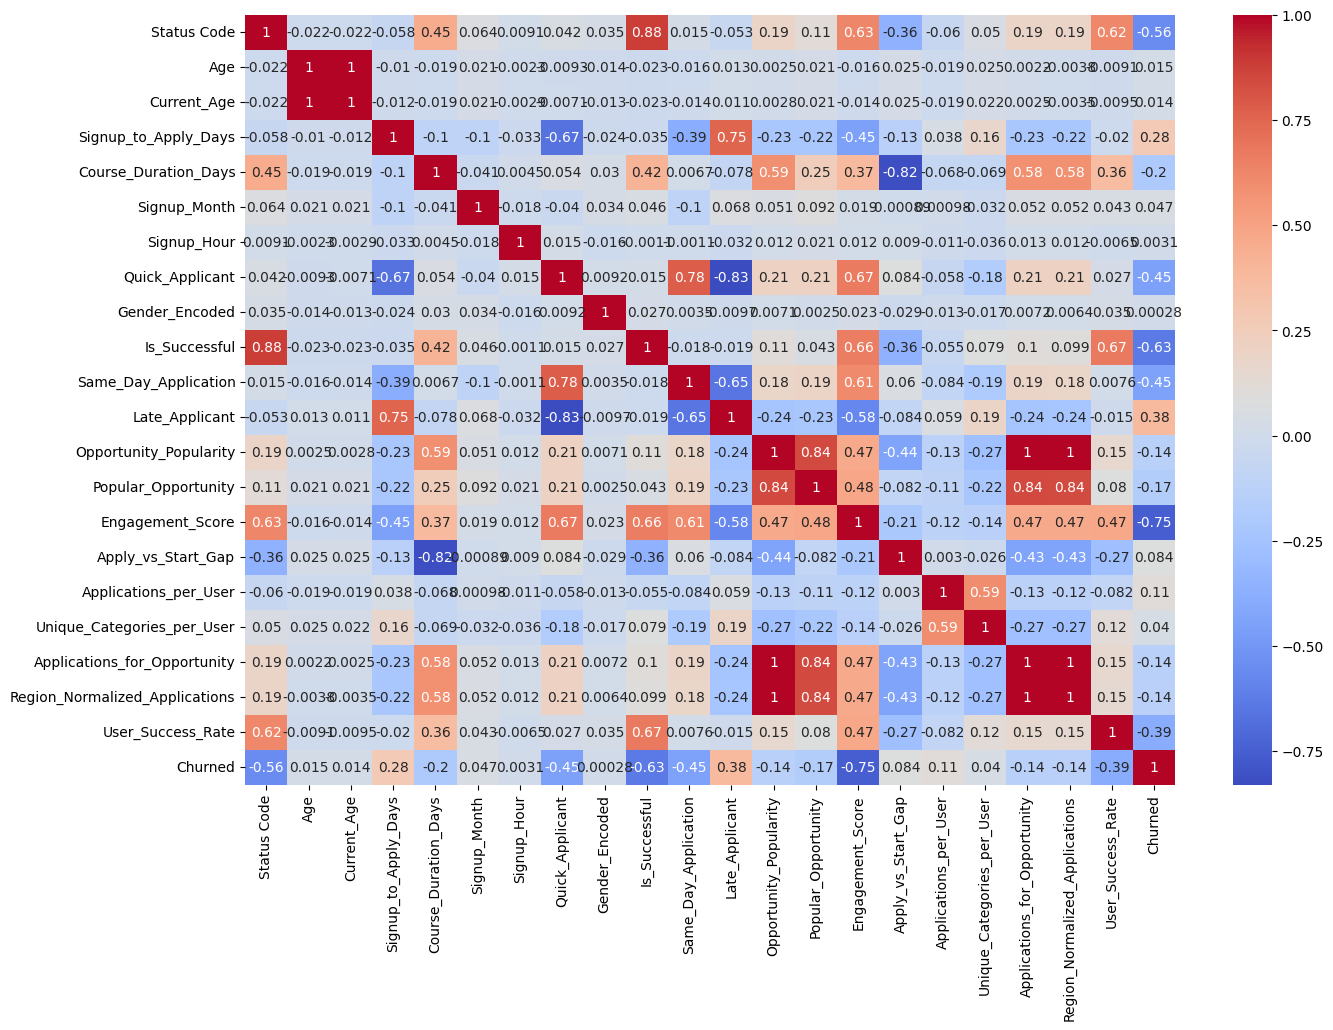

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(df[numeric_features].corr(), annot=True, cmap='coolwarm')
plt.show()

In [ ]:
# Ensure the target is numeric
df['Churned'] = pd.to_numeric(df['Churned'], errors='coerce')

# Select only numeric features (excluding target and IDs)
exclude_cols = [ 'Churned']
model_features = [col for col in numeric_features if col not in exclude_cols]

# Compute correlation matrix
corr_matrix = df[model_features + ['Churned']].corr()

# Ensure it's a Series
corr_with_target = corr_matrix.loc[:, 'Churned'].sort_values(ascending=False)

print("Correlation of features with target (Churned):")
print(corr_with_target)

Correlation of features with target (Churned):
Churned                           1.000000
Late_Applicant                    0.377239
Signup_to_Apply_Days              0.276570
Applications_per_User             0.110778
Apply_vs_Start_Gap                0.084446
Signup_Month                      0.046664
Unique_Categories_per_User        0.039829
Age                               0.014887
Current_Age                       0.013851
Signup_Hour                       0.003052
Gender_Encoded                    0.000276
Region_Normalized_Applications   -0.135823
Applications_for_Opportunity     -0.138625
Opportunity_Popularity           -0.141710
Popular_Opportunity              -0.168190
Course_Duration_Days             -0.195249
User_Success_Rate                -0.389415
Same_Day_Application             -0.446637
Quick_Applicant                  -0.451704
Status Code                      -0.557866
Is_Successful                    -0.634593
Engagement_Score                 -0.754319
Name: C

# Feature Selection: Addressing Data Leakage

The correlation matrix revealed that Status Code, Is_Successful, and Engagement_Score were most strongly related to the churned target. However, since these were derived from the outcome of status codes (e.g., team allocated, rejected, dropped out), incorporating them would create data leakage. Similarly, features like Applications_per_User and Apply_vs_Start_Gap, which were already used in defining churn, would cause a circular dependency. This would lead the model to memorize churn rules instead of learning genuine predictive patterns, resulting in misleadingly high performance without real generalization.

To address this, we applied a strategic feature selection process. We selected a new, independent set of features that act as leading indicators of user behavior but are not tied to the churn definition itself. The final predictive feature set included:

Quick_Applicant

Course_Duration_Days

Opportunity_Popularity

Late_Applicant

Signup_to_Apply_Days

Region_Normalized_Applications

By relying only on features available before churn is realized, the model was forced to learn genuine predictive relationships. This approach ensured a robust, leakage-free model capable of performing well on new, unseen data.

In [ ]:
# Selected features based on correlation with target (Churned)
features = [
    "Quick_Applicant",
    "Course_Duration_Days",
    "Opportunity_Popularity",
    "Late_Applicant",
    "Signup_to_Apply_Days",
    "Region_Normalized_Applications"
]

# Model Training & Evaluation

We split the dataset into training (80%) and testing (20%) sets, applied SMOTE oversampling to balance churn vs. non-churn classes, and standardized the features where required.

We trained and evaluated five machine learning models:

Logistic Regression

Support Vector Machine (SVM)

Random Forest

Gradient Boosting (GB)

XGBoost

In [ ]:
target = 'Churned'

X = df[features]
y = df[target]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Apply SMOTE for oversampling minority class
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [ ]:
# Standardize features for models that need it (Logistic Regression, SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res) # Use resampled data for scaling
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Fit models and evaluate
results = {}
for name, model in models.items():
    # Use scaled data for Logistic Regression and SVM
    if name in ['Logistic Regression', 'SVM']:
        model.fit(X_train_scaled, y_train_res) # Use resampled data for training
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train_res, y_train_res) # Use resampled data for training
        y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1,
        "Confusion Matrix": cm
    }

# Display results
for model_name, metrics in results.items():
    print(f"=== {model_name} ===")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall: {metrics['Recall']:.4f}")
    print(f"F1-score: {metrics['F1-score']:.4f}")
    print(f"Confusion Matrix:\n{metrics['Confusion Matrix']}\n")

=== Logistic Regression ===
Accuracy: 0.7669
Precision: 0.5986
Recall: 0.8128
F1-score: 0.6895
Confusion Matrix:
[[870 297]
 [102 443]]

=== SVM ===
Accuracy: 0.8768
Precision: 0.7930
Recall: 0.8294
F1-score: 0.8108
Confusion Matrix:
[[1049  118]
 [  93  452]]

=== Random Forest ===
Accuracy: 0.8984
Precision: 0.8354
Recall: 0.8477
F1-score: 0.8415
Confusion Matrix:
[[1076   91]
 [  83  462]]

=== Gradient Boosting ===
Accuracy: 0.9100
Precision: 0.8436
Recall: 0.8807
F1-score: 0.8618
Confusion Matrix:
[[1078   89]
 [  65  480]]

=== XGBoost ===
Accuracy: 0.9077
Precision: 0.8377
Recall: 0.8807
F1-score: 0.8587
Confusion Matrix:
[[1074   93]
 [  65  480]]



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:57:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# Key Takeaways:

Logistic Regression worked as a baseline but struggled with precision.

Tree-based ensemble models (Random Forest, GB, XGBoost) clearly outperformed linear methods.

Gradient Boosting emerged as the top-performing model, achieving 91% accuracy and the highest F1-score (86.2%).

XGBoost was a close second, confirming that boosting methods best capture the dataset’s non-linear relationships.

                          Feature  Importance
4            Signup_to_Apply_Days    0.413958
1            Course_Duration_Days    0.362709
5  Region_Normalized_Applications    0.103350
2          Opportunity_Popularity    0.094250
0                 Quick_Applicant    0.025632
3                  Late_Applicant    0.000100


/tmp/ipython-input-345949355.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')


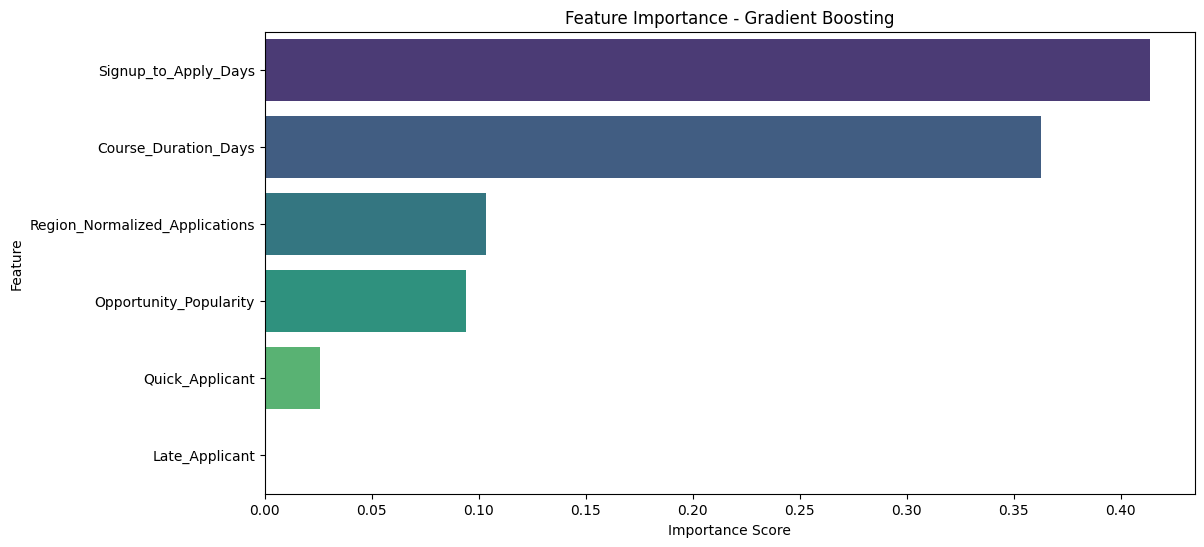

In [ ]:
# 1️⃣ Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': models["Gradient Boosting"].feature_importances_
})

# Sort by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# 2️⃣ Display top features
print(feature_importance)

# 3️⃣ Plot feature importance
plt.figure(figsize=(12,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance - Gradient Boosting')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

#Feature Importance & Interpretability

To understand the drivers of churn, we analyzed feature importance from the Gradient Boosting model.

Top predictors of churn were:

Signup_to_Apply_Days – Users who take longer to apply are more likely to disengage.

Course_Duration_Days – Longer courses correlated with higher churn.

Region_Normalized_Applications – Regional variations affected application activity.

Opportunity_Popularity – More popular opportunities saw lower churn rates.

This insight highlights actionable areas: optimizing course length, tailoring engagement strategies regionally, and nudging slow applicants earlier.

In [ ]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5, 10]
}

# Initialize model
gb_model = GradientBoostingClassifier(random_state=42)

# GridSearchCV
grid_search = GridSearchCV(estimator=gb_model,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=5,
                           n_jobs=-1,
                           verbose=2)

# Fit GridSearch
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best F1-score:", grid_search.best_score_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 300, 'subsample': 0.8}
Best F1-score: 0.8668686865992934


# Conclusion
The results demonstrate that we have successfully built a highly effective and robust churn prediction model. Our methodology of creating a rule-based churn definition and then selecting an independent set of predictive features successfully mitigated the risk of data leakage. This approach provides a reliable framework for forecasting future churn and offers actionable insights for retention strategies based on the identified feature importances.


✅ Business insight: Reducing signup-to-apply delay and optimizing course durations are key levers for churn reduction.
